### LSTM 층 2개로 돌려보기: 열 1개 데이터로, chatGPT 사용
층이 여러 개일 때   
장점: 훨씬 정교한 예측이 가능해 짐!   
단점: 학습 시간 크게 증가, 과적합 위험 증가(과적합 해소를 위해 Dropout 또는 EarlyStopping을 사용하는 것이 좋음)   
주의: 마지막 층만 빼고, return_sequences=True 를 이용해 위층에서 아래층으로 입력 시퀀스 전체를 넘겨주어야 함!

In [ ]:
# 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense  # RNN 모델
from tensorflow.keras.layers import LSTM  # LSTM 모델

#### 데이터 다루기

In [3]:
# 1. 데이터 불러오기
df = pd.read_csv('../AAME.csv')

# 2. Open 열만 사용
df_open = df['Open'].values.reshape(-1, 1)  # reshape: 열이 1개만 남으면 df는 2차원 형태가 풀리므로, 억지로 다시 2차원 형태를 만듦

print(df_open)

# 3. 데이터 결측치 제거, 정규화
df_open = df_open[df_open != 0.0].reshape(-1, 1)  # 0.0값은 결측치이므로 행 제거

scaler = MinMaxScaler()
df_scaled_open = scaler.fit_transform(df_open)  # 정규화

[[0.       ]
 [0.       ]
 [0.       ]
 ...
 [2.25     ]
 [2.1099999]
 [2.1099999]]


In [4]:
# 4. 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 30  # 예: 30일 동안의 데이터를 기반으로 다음날 예측
X, y = create_sequences(df_scaled_open, sequence_length)  # 시퀀스 데이터 생성

In [5]:
# 5. 훈련/검증 데이터 분할
split = int(len(X) * 0.8)
X_test, X_train = X[:split], X[split:]
y_test, y_train = y[:split], y[split:]

#### stacked(다층) LSTM 모델

In [6]:
# 6-2. LSTM 모델 정의
model2 = Sequential()
model2.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(sequence_length, 1))) # 첫 LSTM: 시퀀스 전체를 반환
model2.add(LSTM(32))  # 두 번째 LSTM: 마지막 출력만 사용
model2.add(Dense(1))

model2.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse', 'mae'])

c:\Users\jt341\anaconda3\envs\2025AI\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# 7. 모델 학습
history2 = model2.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0105 - mae: 0.0727 - mse: 0.0105 - val_loss: 0.0027 - val_mae: 0.0410 - val_mse: 0.0027
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.8001e-04 - mae: 0.0152 - mse: 3.8001e-04 - val_loss: 6.1218e-04 - val_mae: 0.0163 - val_mse: 6.1218e-04
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.8512e-04 - mae: 0.0100 - mse: 1.8512e-04 - val_loss: 3.9259e-04 - val_mae: 0.0112 - val_mse: 3.9259e-04
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.7166e-04 - mae: 0.0096 - mse: 1.7166e-04 - val_loss: 3.9147e-04 - val_mae: 0.0117 - val_mse: 3.9147e-04
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.7191e-04 - mae: 0.0094 - mse: 1.7191e-04 - val_loss: 3.8441e-04 - val_mae: 0.0112 - val_mse: 3.8441e-04
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 1.6555e-04 - mae: 0.0093 - mse: 1.6555e-04 - val_loss: 3.6229e-04 - val_mae: 0.0109 - val_mse: 3.6229e-04
Epoch 7/15
54/54 ━━━━━━━━━

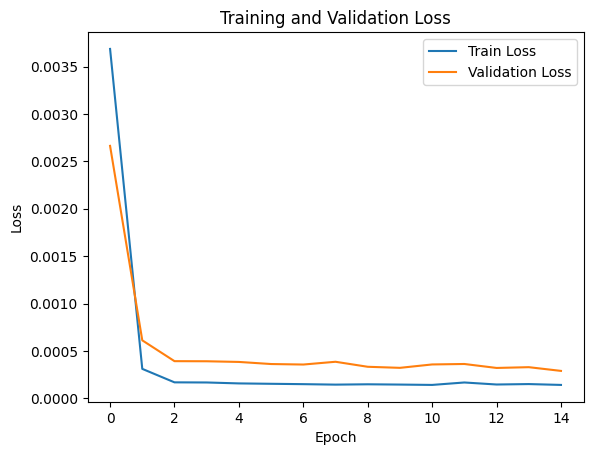

In [8]:
# 8. 결과 시각화
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


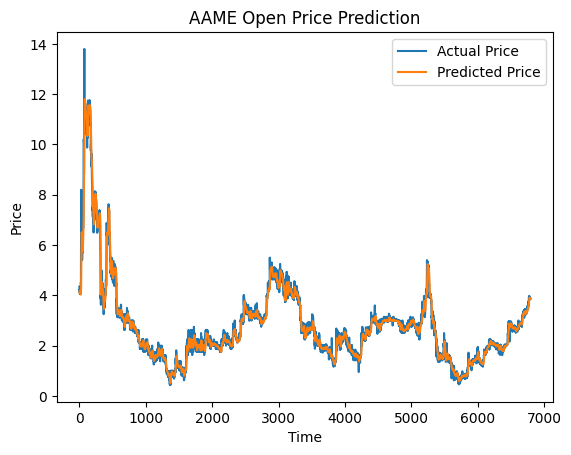

In [9]:
# 9. 예측 및 역정규화
predicted = model2.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test)

# 10. 예측 결과 시각화
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.legend()
plt.title('AAME Open Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

#### 결과 평가
예측 결과 시각화 그래프를 보니 아무래도 더 정확해지긴 한 듯? 그치만 1층짜리 LSTM도 정확도가 엄청 높았다 보니 잘 구분은 안 된다. 더 나쁜 데이터를 쓰거나 한 시퀀스 묶음 크기를 줄여봐야 할 듯.